In [ ]:
from fastai.tabular.all import *
from fastai.collab import *
from fastdownload import FastDownload
from hits_recsys.collab import *

In [ ]:
url = 'https://raw.githubusercontent.com/MenshikovDmitry/TSU_AI_Course/main/module_1.%20Recommender%2BDevOps/dataset/'
files = ('ratings_train.dat ratings_test.dat movies.dat users.dat').split()
d = FastDownload()

In [ ]:
paths = L(d.download(url+f) for f in files); paths

(#4) [Path('/home/slakter/.fastdownload/archive/ratings_train.dat'),Path('/home/slakter/.fastdownload/archive/ratings_test.dat'),Path('/home/slakter/.fastdownload/archive/movies.dat'),Path('/home/slakter/.fastdownload/archive/users.dat')]

In [ ]:
df, df_test = read_movielens(paths[0],paths[2]), read_movielens(paths[1],paths[2])
df.head()

,userId,movieId,rating,title
0,3539,2478,5,Three Amigos! (1986)
1,1358,2478,1,Three Amigos! (1986)
2,2565,2478,1,Three Amigos! (1986)
3,4819,2478,2,Three Amigos! (1986)
4,5763,2478,1,Three Amigos! (1986)


In [ ]:
dls = CollabDataLoaders.from_df(df, item_name='title', bs=256)

In [ ]:
class EmbeddingDotBias(Module):
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [Embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, x):
        users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]
    
    @classmethod
    def from_classes(cls, n_factors, classes, user=None, item=None, y_range=None):
        "Build a model with `n_factors` by inferring `n_users` and  `n_items` from `classes`"
        if user is None: user = list(classes.keys())[0]
        if item is None: item = list(classes.keys())[1]
        res = cls(n_factors, len(classes[user]), len(classes[item]), y_range=y_range)
        res.classes,res.user,res.item = classes,user,item
        return res

In [ ]:
model = EmbeddingDotBias.from_classes(50, dls.classes, y_range=(0,5.5))
learn = Learner(dls, model, loss_func=MSELossFlat())

epoch,train_loss,valid_loss,time
0,0.850507,0.859185,00:22
1,0.795360,0.793991,00:22
2,0.735522,0.750532,00:22
3,0.644753,0.723958,00:21
4,0.585575,0.720772,00:21


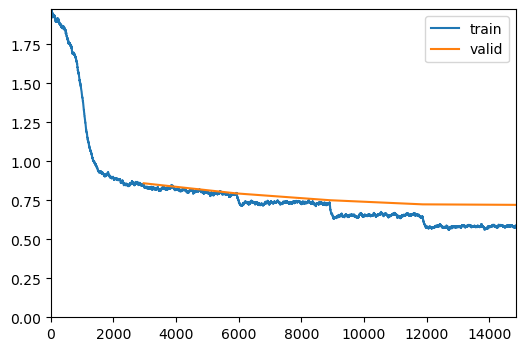

In [ ]:
learn.fit_one_cycle(5,5e-3, wd=0.1, cbs=[ShowGraphCallback()])

In [ ]:
res = learn.get_preds(dl=dls.test_dl(df_test), with_loss=True)

In [ ]:
torch.sqrt(res[2].mean())

TensorBase(0.8463)